# Download all data

This notebook downloads all GitHub activity for a number of organizations
within a (preferably long) time range.

It will extract all issues, PRs, and comments that were updated within a
window of interest. It will then save them to disk as CSV files.

It will loop through organizations and break the total amount of
time queried into 6 month intervals in order to avoid GItHub's 100 page
limit on queries.

In [2]:
from update_mod import GitHubGraphQlQuery, extract_comments

In [3]:
import requests
import pandas as pd
import os
from datetime import timedelta
import os.path as op


In [7]:
fmt = "{:%Y-%m-%d}"

# Can optionally use number of days to choose dates
days_per_step = 60
end_date = pd.datetime.today()
start_date = pd.to_datetime("2019-01-01")

# github_orgs = ["jupyterhub", "jupyter", "jupyterlab", "jupyter-widgets", "ipython", "binder-examples", "nteract"]
# github_orgs = ["voila-dashboards"]

## Update issues

In [8]:
path_data = op.join('..', '..', 'data')

In [9]:
issue_responses = []
pr_responses = []

for org in github_orgs:
    print(f"\nDownloading org:  {org}\n\n")
    # Initialize dates for the loop
    this_start_date = start_date
    this_end_date = end_date
    days_offset = 0
    
    # Loop through windows of time and update our data
    while this_start_date < end_date:
        # Calculate the offset start/end dates
        this_start_date = start_date + timedelta(days=days_offset)
        this_end_date = this_start_date + timedelta(days=days_per_step)

        this_start_date_str = fmt.format(this_start_date)
        this_end_date_str = fmt.format(this_end_date)
        print(f"{this_start_date_str}..{this_end_date_str}")

        # Set up the query we'll use
        query_issues = f"is:issue user:{org} updated:{this_start_date_str}..{this_end_date_str}"
        ghq_iss = GitHubGraphQlQuery(query_issues)
        ghq_iss.request()
        if ghq_iss.data is None:
            days_offset += days_per_step
            continue
        issue_responses.append(ghq_iss)
        
        # Query for pull request activity
        query_prs = f"is:pr user:{org} created:{this_start_date_str}..{this_end_date_str}"
        ghq_pr = GitHubGraphQlQuery(query_prs)
        ghq_pr.request()
        if ghq_pr.data is None:
            continue
        pr_responses.append(ghq_pr)
    
        days_offset += days_per_step
        
    # Combine Issues and pull comments
    issues = pd.concat([ii.data for ii in issue_responses])
    issues_comments = issues.pop("comments")
    issues_comments = extract_comments(issues_comments)

    # Combine PRs and pull comments
    prs = pd.concat([ii.data for ii in pr_responses])
    prs_comments = prs.pop('comments')
    prs_comments = extract_comments(prs_comments)
    
    # Combine the comments
    comments = pd.concat([prs_comments, issues_comments])

    # Add a PR-specific field for closed PRs
    prs['mergedBy'] = prs['mergedBy'].map(lambda a: a['login'] if a is not None else None)
    
    path_folder = op.join(path_data, org)
    os.makedirs(path_folder, exist_ok=True)
    
    print(f"Saving to {path_folder}")
    prs.to_csv(op.join(path_folder, 'prs.csv'))
    issues.to_csv(op.join(path_folder, 'issues.csv'))
    comments.to_csv(op.join(path_folder, 'comments.csv'))
    print(f"Finished downloading for {org}\n========")




2019-01-01..2019-03-02
Found 11 items, which will take 1 pages
Found 15 items, which will take 1 pages
2019-03-02..2019-05-01
Found 12 items, which will take 1 pages
Found 25 items, which will take 1 pages
2019-05-01..2019-06-30
Found 71 items, which will take 2 pages


IntProgress(value=0, description='Downloading:', max=2)

Found 114 items, which will take 3 pages


IntProgress(value=0, description='Downloading:', max=3)

2019-06-30..2019-08-29
Found 76 items, which will take 2 pages


IntProgress(value=0, description='Downloading:', max=2)

Found 69 items, which will take 2 pages


IntProgress(value=0, description='Downloading:', max=2)

2019-08-29..2019-10-28
Found 61 items, which will take 2 pages


IntProgress(value=0, description='Downloading:', max=2)

Found 80 items, which will take 2 pages


IntProgress(value=0, description='Downloading:', max=2)

2019-10-28..2019-12-27
Found 65 items, which will take 2 pages


IntProgress(value=0, description='Downloading:', max=2)

Found 45 items, which will take 1 pages
2019-12-27..2020-02-25
Found 40 items, which will take 1 pages
Found 7 items, which will take 1 pages
2020-02-25..2020-04-25
Found 0 items, which will take 0 pages
Found no entries for query is:issue user:voila-dashboards updated:2020-02-25..2020-04-25
Saving to ../../data/voila-dashboards
Finished downloading for voila-dashboards


## Combine comments

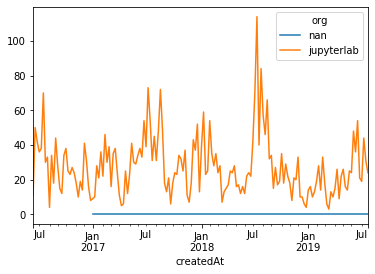

In [82]:
prs_new = prs.copy()
prs_new['createdAt'] = prs_new['createdAt'].apply(pd.to_datetime)
prs_new.resample('W', on='createdAt').agg({'id': 'count', 'org': 'first'}).set_index('org', append=True).unstack('org')['id'].interpolate('linear').plot()